In [28]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, brier_score_loss, classification_report
import matplotlib.pyplot as plt
import os

In [29]:
import subprocess
from pathlib import Path

# Make sure we can open the db file
try:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
    os.chdir(root)
except Exception:
    while not (Path.cwd() / "data").exists() and Path.cwd() != Path.home():
        os.chdir("..")

print("Working directory:", Path.cwd())

Working directory: /Users/ecasto/cs230-project


In [30]:
conn = sqlite3.connect("data/route_events.db")
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables:", tables)


Tables: [('routes',), ('events',), ('route_events',)]


In [31]:
route_events_df = pd.read_sql("SELECT * FROM route_events LIMIT 5;", conn)
route_events_df.head()


,route_id,event_id,county,county_sequence
0,1,543131,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,1
1,1,528899,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,1
2,1,487385,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,1
3,1,491275,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,1
4,1,498976,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,1


In [32]:
pd.read_sql("SELECT * FROM routes LIMIT 5;", conn).head()

,route_id,county_count,counties,created_at
0,1,4,"NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,SAN ...",2025-11-01 19:14:50
1,2,5,"SANTA YNEZ MOUNTAINS EASTERN RANGE,SAN JOAQUIN...",2025-11-01 19:14:50
2,3,8,SANTA LUCIA MOUNTAINS AND LOS PADRES NATIONAL ...,2025-11-01 19:14:50
3,4,6,"HUMBOLDT,W CENTRAL S.J. VALLEY,SAN GORGONIO PA...",2025-11-01 19:14:50
4,5,10,"TRINITY,Carquinez Strait and Delta,ORANGE COUN...",2025-11-01 19:14:50


In [33]:
pd.read_sql("SELECT * FROM events LIMIT 5;", conn).head()

,event_id,cz_name,event_type,year,month_name,begin_date_time,end_date_time,injuries_direct,injuries_indirect,deaths_direct,...,damage_crops,magnitude,magnitude_type,tor_f_scale,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative
0,545981,TULARE CTY MTNS,Drought,2014,November,01-NOV-14 00:00:00,30-NOV-14 23:59:00,0,0,0,...,0.0,None,None,None,None,None,None,None,The California drought continued in full force...,None
1,545982,INDIAN WELLS VLY,Drought,2014,November,01-NOV-14 00:00:00,30-NOV-14 23:59:00,0,0,0,...,0.0,None,None,None,None,None,None,None,The California drought continued in full force...,None
2,535048,SAN DIEGO COUNTY MOUNTAINS,Wildfire,2014,July,03-JUL-14 09:30:00,06-JUL-14 08:15:00,0,4,0,...,0.0,None,None,None,None,None,None,None,The Banner Fire started around 0930 PST on Jul...,None
3,539719,S SIERRA FOOTHILLS,Drought,2014,September,01-SEP-14 00:00:00,30-SEP-14 23:59:00,0,0,0,...,0.0,None,None,None,None,None,None,None,The California drought continued in full force...,None
4,539721,KERN CTY MTNS,Drought,2014,September,01-SEP-14 00:00:00,30-SEP-14 23:59:00,0,0,0,...,0.0,None,None,None,None,None,None,None,The California drought continued in full force...,None


In [34]:
# ---------------------------------------------------------------
# Load labeled data from routes_scores.db
# ---------------------------------------------------------------

conn2 = sqlite3.connect("data/routes_scores.db")

# List available tables
print(conn2.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall())



[('routes',)]


In [35]:
# Preview a few rows
df = pd.read_sql("SELECT * FROM routes;", conn2)
#df.head()


In [36]:
# Show columns of routes_scores
print(conn2.execute("PRAGMA table_info(routes);").fetchall())

[(0, 'route_id', 'INTEGER', 0, None, 1), (1, 'counties', 'TEXT', 1, None, 0), (2, 'impact_score', 'REAL', 1, None, 0), (3, 'impacting_delivery', 'INTEGER', 1, None, 0)]


In [37]:
# ---------------------------------------------------------------
# Basic checks and preprocessing
# ---------------------------------------------------------------
numeric_features = ["impact_score"]
categorical_features = ["counties"]
target = "impacting_delivery"
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())
df[categorical_features] = df[categorical_features].fillna("Unknown")

print("Label distribution:")
print(df[target].value_counts(normalize=True))


Label distribution:
impacting_delivery
0    0.76505
1    0.23495
Name: proportion, dtype: float64


In [38]:
# ---------------------------------------------------------------
# Split data (70/15/15)
# ---------------------------------------------------------------
train, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df[target])
train, val  = train_test_split(train, test_size=0.1765, random_state=42, stratify=train[target])

print("Train:", train.shape)
print("Val:", val.shape)
print("Test:", test.shape)

X_train = train[numeric_features + categorical_features]
y_train = train[target]

X_val = val[numeric_features + categorical_features]
y_val = val[target]

X_test = test[numeric_features + categorical_features]
y_test = test[target]

Train: (13999, 4)
Val: (3001, 4)
Test: (3000, 4)


In [39]:
# ---------------------------------------------------------------
# Preprocessing: Standardization + One-Hot Encoding
# ---------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [40]:
# ---------------------------------------------------------------
# Logistic Regression model
# ---------------------------------------------------------------
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="liblinear",
        max_iter=500,
        class_weight="balanced"
    ))
])

clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
# ---------------------------------------------------------------
# Evaluate performance
# ---------------------------------------------------------------
probs = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

auc_pr = auc(recall, precision)
brier  = brier_score_loss(y_test, probs)

print("AUPRC:", auc_pr)
print("Brier Score:", brier)
print("\nClassification Report:\n")
print(classification_report(y_test, clf.predict(X_test)))

# Save PR Curve
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AUC={auc_pr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
os.makedirs("results", exist_ok=True)
plt.savefig("results/pr_curve_logreg_sklearn.png", dpi=150)
plt.close()

AUPRC: 1.0
Brier Score: 0.008834679427099262

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2295
           1       0.95      1.00      0.97       705

    accuracy                           0.99      3000
   macro avg       0.98      0.99      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [42]:
# ---------------------------------------------------------------
# Feature importance
# ---------------------------------------------------------------
model = clf.named_steps["model"]
feature_names = clf.named_steps["preprocess"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "weight": model.coef_[0]
}).sort_values(by="weight", ascending=False)

coef_df.to_csv("results/logreg_coefficients_sklearn.csv", index=False)
coef_df.head(10)

,feature,weight
0,num__impact_score,16.212152
513,"cat__counties_CALABASAS AND AGOURA HILLS,India...",0.473715
4141,"cat__counties_LAKE,SANTA LUCIA MOUNTAINS,South...",0.473283
5073,"cat__counties_MENDOCINO,MARIPOSA - MADERA LOWE...",0.471763
5866,cat__counties_Mountains Southwest Shasta Count...,0.471759
9812,cat__counties_SANTA MONICA MOUNTAINS RECREATIO...,0.468282
3855,"cat__counties_KERN RIVER VALLEY,SAN BERNARDINO...",0.467768
1732,"cat__counties_DEL NORTE,Morongo Basin,NORTHWES...",0.466793
7429,"cat__counties_Orange County Coastal,SOUTHERN M...",0.465821
7798,"cat__counties_RIVERSIDE,MARIN,SAN DIEGO COUNTY...",0.465459


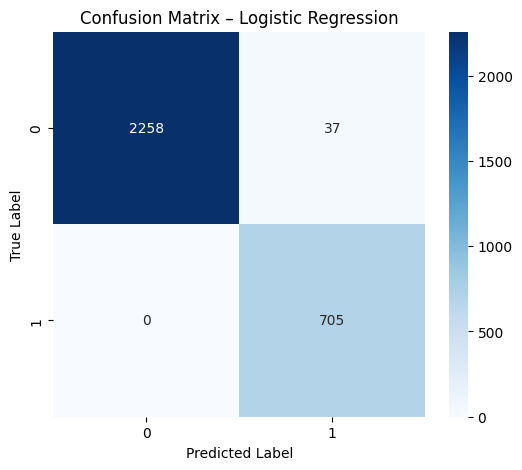

In [43]:
#Confusion matrix for logistic regression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_lr = (probs >= 0.5).astype(int)
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_logistic_regression.png", dpi=150)
plt.show()


Identify the routes the model got most wrong

In [49]:
results_df = X_test.copy()
results_df["y_true"] = y_test.values
results_df["y_prob"] = probs
results_df["y_pred"] = (results_df["y_prob"] >= 0.5).astype(int)

# FALSE NEGATIVES
worst_fn = results_df[(results_df.y_true == 1) & (results_df.y_pred == 0)] \
    .sort_values("y_prob") \
    .head(10)

# FALSE POSITIVES
worst_fp = results_df[(results_df.y_true == 0) & (results_df.y_pred == 1)] \
    .sort_values("y_prob", ascending=False) \
    .head(10)

worst_fn.to_csv("results/lr_worst_fn.csv", index=False)
worst_fp.to_csv("results/lr_worst_fp.csv", index=False)

worst_fn, worst_fp

(Empty DataFrame
 Columns: [impact_score, counties, y_true, y_prob, y_pred]
 Index: [],
        impact_score                                           counties  \
 17026      0.249992  VENTURA COUNTY BEACHES,E CENTRAL S.J. VALLEY,S...   
 6364       0.249948  MONO,NORTHERN MONTEREY BAY,VENTURA COUNTY INTE...   
 7292       0.249942  ORANGE COUNTY COASTAL,PLANADA-LEGRAND-SNELLING...   
 1105       0.249898  WESTERN SAN JOAQUIN VALLEY IN KERN COUNTY,ALAM...   
 16326      0.249869  WESTERN SAN FERNANDO VALLEY,SOUTH CENTRAL SISK...   
 9002       0.249845  EASTERN SANTA CLARA HILLS,CENTRAL VENTURA COUN...   
 17702      0.249793  CENTRAL SIERRA,SOUTHERN TRINITY,VENTURA COUNTY...   
 1197       0.249717  SANTA BARBARA,WESTERN ANTELOPE VALLEY FOOTHILL...   
 4690       0.249716  WESTERN KERN COUNTY,CENTRAL SIERRA,YOLO,Kern C...   
 8580       0.249712  NORTHEAST FOOTHILLS/SACRAMENTO VALLEY,SANTA CL...   
 
        y_true    y_prob  y_pred  
 17026       0  0.681909       1  
 6364        0 

County-level misclassification

In [50]:
def explode_counties(df):
    df_copy = df.copy()
    df_copy["county_list"] = df_copy["counties"].str.split(",")
    return df_copy.explode("county_list")

expanded = explode_counties(results_df)

# Compute misclassification rates
expanded["is_wrong"] = (expanded.y_true != expanded.y_pred).astype(int)

county_error = expanded.groupby("county_list")["is_wrong"].mean().sort_values(ascending=False)

county_error.head(20)

county_list
CENTRAL SIERRA                                                     0.072464
ALAMEDA                                                            0.067797
SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - THE INLAND EMPIRE    0.064516
NORTHERN MONTEREY BAY                                              0.055556
SAN LUIS OBISPO COUNTY BEACHES                                     0.054795
SANTA BARBARA COUNTY SOUTH COAST                                   0.050000
KERN                                                               0.050000
WESTERN SISKIYOU COUNTY                                            0.046875
CONTRA COSTA                                                       0.046875
RIVERSIDE                                                          0.046875
MARIPOSA                                                           0.046512
MERCED                                                             0.045455
INYO                                                               0.045455


In [44]:
results = {
    "AUPRC": auc_pr,
    "brier_score": brier
}

pd.DataFrame([results]).to_csv("results/logreg_metrics_sklearn.csv", index=False)

print("\n✅ Logistic Regression (sklearn) baseline complete!")


✅ Logistic Regression (sklearn) baseline complete!


In [45]:
conn2.close()
#Save results for error analysis
np.save("results/lr_probs.npy", probs)
np.save("results/lr_y_test.npy", y_test.values)